# Bayesian Factor Analysis Comparison

This notebook compares two Variational Bayesian approaches to Factor Analysis:

1.  **Coupled Inference (Exact/NIG)**: Using a joint **Normal-Inverse-Gamma** prior for the loadings $w_d$ and noise variances $\sigma_d^2$ for each dimension. This preserves the posterior coupling.
2.  **Decoupled Inference (Mean-Field)**: Using a factorized approximation $q(W)q(\Psi)$, assuming independence.

We investigate how the mean-field approximation might underestimate posterior uncertainty or affect learning compared to the coupled approach.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, special
import scipy.linalg as linalg
import procrustes

np.random.seed(137)
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Synthetic Data Generation

In [2]:
# Dimensions
N = 4000
D = 20
K = 5

# True Parameters
# Random W
W_true = np.eye(K).repeat(D // K, axis=0)
# Diagonal Noise
psi_true_diag = np.random.uniform(0.2, 1.0, size=D)

# Generate Latents
Z_true = np.random.randn(N, K)

# Generate Observations
noise = np.random.randn(N, D) * np.sqrt(psi_true_diag)
X = Z_true @ W_true.T + noise

# Center Data
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean

print(f"Data Shape: {X_centered.shape}")

Data Shape: (4000, 20)


0.24284645052827583


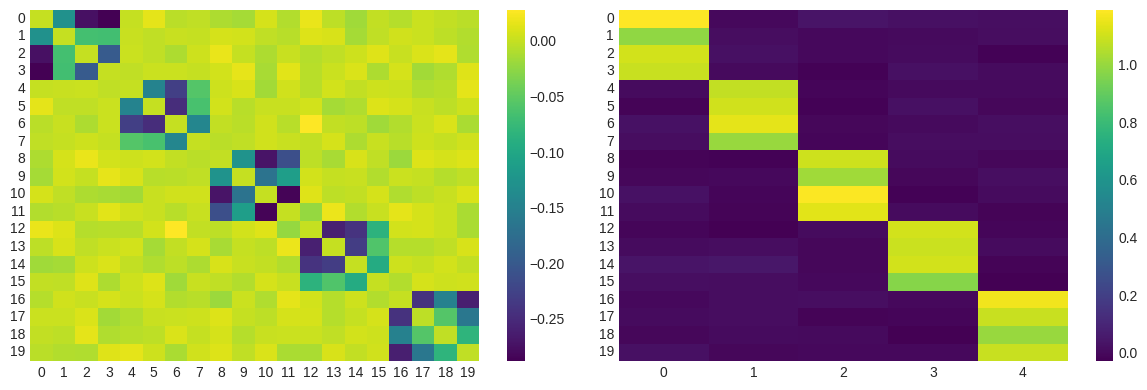

In [3]:
# fa initializer

def initialize_params(X, rank=1):
    U, s, Vh = linalg.svd(X, full_matrices=False)

    A = Vh.T @ np.diag(s) / np.sqrt(len(X))
    B = A[:, rank:]
    A = A[:, :rank]

    return A, np.sum(np.square(B), -1)

A, sig_sqr = initialize_params(X, rank=K)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(np.cov(X_centered.T) - np.diag(sig_sqr) - A @ A.T, cmap='viridis', ax=axes[0])
res = procrustes.rotational(A, W_true)
print(res.error)
sns.heatmap(res.new_a @ res.t, cmap='viridis', ax=axes[1])

fig.tight_layout()

## 2. Coupled Factor Analysis (NIG)

**Prior**: $p(w_d, \sigma_d^2) = \mathcal{N}(w_d | 0, \sigma_d^2 \Lambda_0^{-1}) \times \text{IG}(\sigma_d^2 | a_0, b_0)$.

**Posterior**: $q(w_d, \sigma_d^2) = \text{NIG}(\mu_d, \Lambda_d, a_d, b_d)$.

In [4]:
class CoupledFA:
    def __init__(self, K, D, a0=2.0, b0=2.0):
        self.K = K
        self.D = D
        self.a0 = a0
        self.b0 = b0
        self.Lambda0 = np.eye(K) # Precision matrix for w given sigma
        
        # Variational Parameters
        # For q(Z)
        self.Zn_m = np.zeros((0, K))
        self.S = np.eye(K)
        
        # For q(w_d, sigma_d^2)
        # Shared Lambda component (Lambda_d = Lambda0 + sumZZ)
        self.wd_Lambda = np.array([self.Lambda0 for _ in range(D)])
        self.wd_mu = np.random.randn(D, K)
        self.sig_a = np.ones(D) * self.a0
        self.sig_b = np.ones(D) * self.b0
        
        self.elbo_history = []

    def update_Z(self, X):
        N = X.shape[0]
        E_inv_sig = self.sig_a / self.sig_b  # Shape (D,)
        
        # --- Compute S (Precision of Z) ---
        # S^-1 = I + sum_d E[sigma_d^-2 w_d w_d^T]
        # Identity for NIG: E[sigma^-2 w w^T] = Lambda^-1 + E[sigma^-2] mu mu^T
        I = np.eye(self.K)
        S_inv = np.eye(self.K)
        for d in range(self.D):
            term = I + self.wd_Lambda[d] @ (E_inv_sig[d] * np.outer(self.wd_mu[d], self.wd_mu[d]))
            S_inv += linalg.solve(self.wd_Lambda[d], term)
        
        L_fact = linalg.cho_factor(S_inv)
        log_det_S = - 2 * np.log(np.diag(L_fact[0])).sum() 
        self.S = linalg.cho_solve(L_fact, I)
        
        # --- Compute Means m_n ---
        # coeffs[d] = E[sigma^-2 w_d] = E[sigma^-2] * mu_d
        coeffs = (self.wd_mu.T * E_inv_sig).T # Shape (D, K)
        self.Zn_m = (X @ coeffs) @ self.S
        
        # --- Compute ELBO ---
        # 1. Log Normalization Constants sum_n log Z_n
        # Constant term from E[log p(x|z,theta) p(z)]: 
        # -0.5 * sum_n [ D log(2pi) + sum_d E[log sig^2] + sum_d E[sig^-2] x_nd^2 ]
        E_log_sig2 = np.log(self.sig_b) - special.digamma(self.sig_a)
        term_const = -0.5 * N * (self.D * np.log(2 * np.pi) + np.sum(E_log_sig2))
        
        # Data quadratic term: sum_n sum_d E[sig^-2] x^2
        sum_x2_weighted = np.sum((X**2) @ E_inv_sig)
        term_data = -0.5 * sum_x2_weighted
        
        # Z Integral term: 0.5 sum_n [ m_n^T S^-1 m_n + log|S| ]
        term_z_quad = 0.5 * np.sum( (self.Zn_m @ S_inv) * self.Zn_m )
        term_z_det = 0.5 * N * log_det_S
        
        log_Z_sum = term_const + term_data + term_z_quad + term_z_det
        
        # 2. - KL(q(theta) || p(theta))
        kl_total = 0
        for d in range(self.D):
            # KL for NIG(mu, Lambda, a, b) || NIG(0, Lambda0, a0, b0)
            # IG part
            qa, qb = self.sig_a[d], self.sig_b[d]
            pa, pb = self.a0, self.b0
            kl_ig = pa * np.log(qb/pb) + special.gammaln(pa) - special.gammaln(qa) + (qa - pa)*special.digamma(qa) + qa*(pb/qb - 1.0)
            
            # Normal part (Integrated)
            # 0.5 * [ Tr(L0 L^-1) - K + (a/b) (m-m0)^T L0 (m-m0) + log|L| - log|L0| ]
            qL, qm = self.wd_Lambda[d], self.wd_mu[d]
            pL = self.Lambda0
            
            term_tr = np.trace(linalg.solve(qL, pL, assume_a='pos'))
            term_quad = (qa/qb) * (qm @ pL @ qm) # since m0=0
            sign, log_det_qL = np.linalg.slogdet(qL)
            sign, log_det_pL = np.linalg.slogdet(pL)
            
            kl_norm = 0.5 * (term_tr - self.K + term_quad + log_det_qL - log_det_pL)
            
            kl_total += kl_ig + kl_norm
            
        return log_Z_sum - kl_total

    def m_step(self, X):
        N = X.shape[0]
        # sum_z_zt = sum_n (m_n m_n^T + S)
        sum_z_zt = self.Zn_m.T @ self.Zn_m + N * self.S
        
        for d in range(self.D):
            self.wd_Lambda[d] = self.Lambda0 + sum_z_zt
            
            sum_xz = self.Zn_m.T @ X[:, d]
            self.wd_mu[d] = linalg.solve(self.wd_Lambda[d], sum_xz)
            
            self.sig_a[d] = self.a0 + N / 2.0
            
            sum_x2 = np.sum(X[:, d]**2)
            quad = self.wd_mu[d] @ self.wd_Lambda[d] @ self.wd_mu[d]
            self.sig_b[d] = self.b0 + 0.5 * (sum_x2 - quad)

    def fit(self, X, max_iter=100, tol=1e-4, initialize=True):
        if initialize:
            self.wd_mu, sig_sqr = initialize_params(X, rank=self.K)
            self.sig_a = np.ones(self.D) * (self.a0 + len(X) / 2)
            self.sig_b = sig_sqr * self.sig_a
            
        self.elbo_history = []
        
        for i in range(max_iter):
            elbo = self.update_Z(X)
            self.elbo_history.append(elbo)
            
            self.m_step(X)
            
            if i > 0 and abs(self.elbo_history[-1] - self.elbo_history[-2]) < tol:
                break
        
        return self.elbo_history

## 3. Decoupled Factor Analysis (Mean-Field)

**Posterior factors**: $q(w_d)q(\sigma_d^2)$.

In [5]:
class DecoupledFA:
    def __init__(self, K, D, a0=2.0, b0=2.0):
        self.K = K
        self.D = D
        self.a0 = a0
        self.b0 = b0
        self.Sigma0 = np.eye(K)
        self.Sigma0_inv = np.linalg.inv(self.Sigma0)
        
        self.Zn_m = np.zeros((0, K))
        self.S = np.eye(K)
        
        self.wd_mu = np.random.randn(D, K)
        self.wd_Sigma = np.array([np.eye(K) for _ in range(D)])
        self.sig_a = np.ones(D) * self.a0
        self.sig_b = np.ones(D) * self.b0
        
        self.elbo_history = []

    def kl_div(self):
        # KL(q(w) || p(w)) + KL(q(sig) || p(sig))
        kl = 0
        sign, log_det_p = np.linalg.slogdet(self.Sigma0)
        for d in range(self.D):
            # Normal KL
            # q(w) = N(mu, Sigma), p(w) = N(0, Sigma0)
            sign, log_det_q = np.linalg.slogdet(self.wd_Sigma[d])
            tr_term = np.trace(self.Sigma0_inv @ self.wd_Sigma[d])
            quad_term = self.wd_mu[d] @ self.Sigma0_inv @ self.wd_mu[d]
            kl += 0.5 * (tr_term + quad_term - self.K + log_det_p - log_det_q)
            
            # IG KL
            qa, qb = self.sig_a[d], self.sig_b[d]
            pa, pb = self.a0, self.b0
            kl += pa * np.log(qb/pb) + special.gammaln(pa) - special.gammaln(qa) + (qa - pa)*special.digamma(qa) + qa*(pb/qb - 1.0)
        return kl

    def update_Z(self, X):
        N = X.shape[0]
        E_inv_sig = self.sig_a / self.sig_b
        
        S_inv = np.eye(self.K)
        sum_quad_W = 0
        for d in range(self.D):
            E_ww = self.wd_Sigma[d] + np.outer(self.wd_mu[d], self.wd_mu[d])
            S_inv += E_inv_sig[d] * E_ww
            # For ELBO term E[x W z]
            
        self.S = np.linalg.inv(S_inv)
        sign, log_det_S = np.linalg.slogdet(self.S)
        
        coeffs = (self.wd_mu.T * E_inv_sig).T
        self.Zn_m = (X @ coeffs) @ self.S
        
        # --- ELBO (Log Z_n - KL) ---
        # Log Z_n similar to coupled but Constant term differs
        # log p(x,z) exp const: 
        E_log_sig2 = np.log(self.sig_b) - special.digamma(self.sig_a)
        term_const = -0.5 * N * (self.D * np.log(2 * np.pi) + np.sum(E_log_sig2))
        
        sum_x2_weighted = np.sum((X**2) @ E_inv_sig)
        term_data = -0.5 * sum_x2_weighted
        
        # Difference in interaction term for Decoupled:
        # We also have term -0.5 sum_n E[z^T (sum_d sig^-2 E[w w^T]) z] which is -0.5 z^T (S_inv - I) z
        # The algebra leads to the same form: 0.5 * (m S^-1 m + log|S|)
        term_z_quad = 0.5 * np.sum( (self.Zn_m @ S_inv) * self.Zn_m )
        term_z_det = 0.5 * N * log_det_S
        
        log_Z_sum = term_const + term_data + term_z_quad + term_z_det
        
        return log_Z_sum - self.kl_div()

    def m_step(self, X):
        N = X.shape[0]
        E_inv_sig = self.sig_a / self.sig_b
        sum_z_zt = self.Zn_m.T @ self.Zn_m + N * self.S

        I = np.eye(K)
        
        for d in range(self.D):
            Sig_inv = I + self.Sigma0  @ (E_inv_sig[d] * sum_z_zt)
            self.wd_Sigma[d] = linalg.solve(Sig_inv, self.Sigma0)
            
            sum_xz = self.Zn_m.T @ X[:, d]
            self.wd_mu[d] = self.wd_Sigma[d] @ (E_inv_sig[d] * sum_xz)
            
            self.sig_a[d] = self.a0 + N / 2.0
            
            term1 = np.sum(X[:, d]**2)
            term2 = -2 * X[:, d] @ self.Zn_m @ self.wd_mu[d]
            E_ww = self.wd_Sigma[d] + np.outer(self.wd_mu[d], self.wd_mu[d])
            term3 = np.trace(E_ww @ sum_z_zt)
            
            self.sig_b[d] = self.b0 + 0.5 * (term1 + term2 + term3)

    def fit(self, X, max_iter=100, m_step_iters=16, tol=1e-4, initialize=True):
        if initialize:
            self.wd_mu, sig_sqr = initialize_params(X, rank=self.K)
            self.sig_a = np.ones(self.D) * (self.a0 + len(X) / 2)
            self.sig_b = sig_sqr * self.sig_a

        self.elbo_history = []
        for i in range(max_iter):
            elbo = self.update_Z(X)
            self.elbo_history.append(elbo)
            
            for _ in range(m_step_iters):
                self.m_step(X)
            
            if i > 0 and abs(elbo - self.elbo_history[-2]) < tol:
                break
        return self.elbo_history

## 4. Experiment: Fit quality for various sample sizes

In [6]:
data_sizes = [16, 24, 32, 48, 64, 128, 256]
n_runs = 50
D, K = W_true.shape
N_test = 500
X_te = X_centered[- N_test:]
z_te = X_centered[- N_test:]

results_coupled = []
results_decoupled = []

err_coupled = []
err_decoupled = []

for N in data_sizes:
    N_train = N
    N_test = 500
    
    res_c = []
    res_d = []
    err_c = []
    err_d = []

    for r in range(n_runs):
        # Generate Data
        idxs = np.random.choice(np.arange(len(X_centered) - N_test), size=N, replace=False)
        X_tr = X_centered[idxs]

        X_all = np.concatenate([X_tr, X_te], axis=0)
        
        # --- Coupled ---
        c_bfa = CoupledFA(K, D)
        c_bfa.fit(X_tr, max_iter=200, initialize=True)
        elbo_tr = c_bfa.elbo_history[-1]
        
        # Evaluate error on Train
        err_c.append(procrustes.rotational(c_bfa.wd_mu, W_true).error)
        
        # Refit to Test
        c_bfa.fit(X_all, initialize=False)
        res_c.append( (c_bfa.elbo_history[-1] - elbo_tr) / N_test)
        
        # --- Decoupled ---
        d_bfa = DecoupledFA(K, D)
        d_bfa.fit(X_tr, max_iter=200, initialize=True)
        err_d.append(procrustes.rotational(d_bfa.wd_mu, W_true).error)
        elbo_tr = d_bfa.elbo_history[-1]
        
        # Refit to Test
        d_bfa.fit(X_all, initialize=False)
        res_d.append( (d_bfa.elbo_history[-1] - elbo_tr) / N_test)

    results_coupled.append(np.median(res_c))
    results_decoupled.append(np.median(res_d))

    err_coupled.append(np.median(err_c))
    err_decoupled.append(np.median(err_d))
    
    print(f"N={N}: Coupled MLL={results_coupled[-1]:.4f}, Decoupled MLL={results_decoupled[-1]:.4f}, Coupled ERR={err_coupled[-1]:.4f}, Decoupled ERR={err_decoupled[-1]:.4f}")

N=16: Coupled MLL=-29.2476, Decoupled MLL=-29.2649, Coupled ERR=10.6346, Decoupled ERR=12.1754
N=24: Coupled MLL=-29.1967, Decoupled MLL=-29.2100, Coupled ERR=6.5834, Decoupled ERR=8.3123
N=32: Coupled MLL=-29.1663, Decoupled MLL=-29.1745, Coupled ERR=4.3554, Decoupled ERR=5.2807
N=48: Coupled MLL=-29.1187, Decoupled MLL=-29.1250, Coupled ERR=13.6020, Decoupled ERR=14.2134
N=64: Coupled MLL=-29.0878, Decoupled MLL=-29.0901, Coupled ERR=2.1645, Decoupled ERR=2.5273
N=128: Coupled MLL=-29.0094, Decoupled MLL=-29.0113, Coupled ERR=1.0039, Decoupled ERR=1.0756
N=256: Coupled MLL=-28.9491, Decoupled MLL=-28.9503, Coupled ERR=0.5794, Decoupled ERR=0.6083


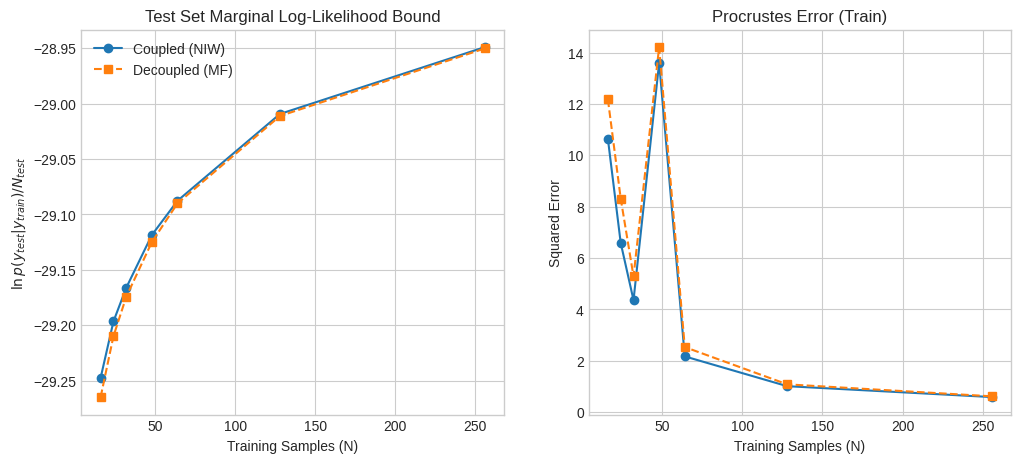

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(data_sizes, results_coupled, 'o-', label='Coupled (NIW)')
plt.plot(data_sizes, results_decoupled, 's--', label='Decoupled (MF)')
plt.xlabel('Training Samples (N)')
plt.ylabel(r'$\ln p(y_{test}|y_{train}) / N_{test}$')
plt.title('Test Set Marginal Log-Likelihood Bound')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(data_sizes, err_coupled, 'o-')
plt.plot(data_sizes, err_decoupled, 's--')
plt.xlabel('Training Samples (N)')
plt.ylabel('Squared Error')
plt.title('Procrustes Error (Train)')

plt.show()

In [8]:
data_sizes = [16, 24, 32, 48, 64, 128, 256]
n_runs = 50
D, K = W_true.shape
N_test = 500
X_te = X_centered[- N_test:]
z_te = X_centered[- N_test:]

results_coupled = []
results_decoupled = []

err_coupled = []
err_decoupled = []

for N in data_sizes:
    N_train = N
    N_test = 500
    
    res_c = []
    res_d = []
    err_c = []
    err_d = []

    for r in range(n_runs):
        # Generate Data
        idxs = np.random.choice(np.arange(len(X_centered) - N_test), size=N, replace=False)
        X_tr = X_centered[idxs]

        X_all = np.concatenate([X_tr, X_te], axis=0)
        
        # --- Coupled ---
        c_bfa = CoupledFA(K, D)
        c_bfa.fit(X_tr, max_iter=200, initialize=False)
        elbo_tr = c_bfa.elbo_history[-1]
        
        # Evaluate error on Train
        err_c.append(procrustes.rotational(c_bfa.wd_mu, W_true).error)
        
        # Refit to Test
        c_bfa.fit(X_all, initialize=False)
        res_c.append( (c_bfa.elbo_history[-1] - elbo_tr) / N_test)
        
        # --- Decoupled ---
        d_bfa = DecoupledFA(K, D)
        d_bfa.fit(X_tr, max_iter=200, initialize=False)
        err_d.append(procrustes.rotational(d_bfa.wd_mu, W_true).error)
        elbo_tr = d_bfa.elbo_history[-1]
        
        # Refit to Test
        d_bfa.fit(X_all, initialize=False)
        res_d.append( (d_bfa.elbo_history[-1] - elbo_tr) / N_test)

    results_coupled.append(np.median(res_c))
    results_decoupled.append(np.median(res_d))

    err_coupled.append(np.median(err_c))
    err_decoupled.append(np.median(err_d))
    
    print(f"N={N}: Coupled MLL={results_coupled[-1]:.4f}, Decoupled MLL={results_decoupled[-1]:.4f}, Coupled ERR={err_coupled[-1]:.4f}, Decoupled ERR={err_decoupled[-1]:.4f}")

N=16: Coupled MLL=-29.2486, Decoupled MLL=-29.2669, Coupled ERR=16.2380, Decoupled ERR=14.5909
N=24: Coupled MLL=-29.1936, Decoupled MLL=-29.2072, Coupled ERR=12.9153, Decoupled ERR=16.2080
N=32: Coupled MLL=-29.1652, Decoupled MLL=-29.1759, Coupled ERR=4.8635, Decoupled ERR=14.7380
N=48: Coupled MLL=-29.1176, Decoupled MLL=-29.1229, Coupled ERR=14.2586, Decoupled ERR=3.6767
N=64: Coupled MLL=-29.0828, Decoupled MLL=-29.0870, Coupled ERR=1.9553, Decoupled ERR=14.4471
N=128: Coupled MLL=-29.0123, Decoupled MLL=-29.0139, Coupled ERR=13.1837, Decoupled ERR=14.2348
N=256: Coupled MLL=-28.9502, Decoupled MLL=-28.9507, Coupled ERR=14.1337, Decoupled ERR=0.5234


## 5. Experiment: Convergence nd Recovery

Coupled Procrustes Error: 0.7464
Decoupled Procrustes Error: 0.8130


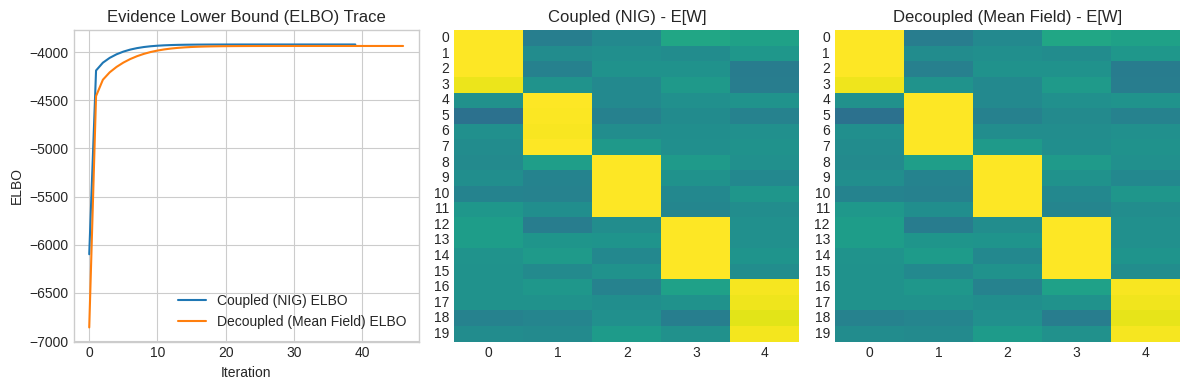

In [9]:
c_fa = CoupledFA(K, D)
c_fa.fit(X_centered[:128])

d_fa = DecoupledFA(K, D)
d_fa.fit(X_centered[:128])

# Compare Parameter Recovery
res_c = procrustes.rotational(c_fa.wd_mu, W_true)
err_c = res_c.error
res_d = procrustes.rotational(d_fa.wd_mu, W_true)
err_d = res_d.error

print(f"Coupled Procrustes Error: {err_c:.4f}")
print(f"Decoupled Procrustes Error: {err_d:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(c_fa.elbo_history, label='Coupled (NIG) ELBO')
axes[0].plot(d_fa.elbo_history, label='Decoupled (Mean Field) ELBO')
axes[0].legend()
axes[0].set_title("Evidence Lower Bound (ELBO) Trace")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("ELBO")

sns.heatmap(res_c.new_a @ res_c.t, ax=axes[1], cmap='viridis', cbar=False, vmax=1, vmin=-1)
axes[1].set_title('Coupled (NIG) - E[W]')
sns.heatmap(res_d.new_a @ res_d.t, ax=axes[2], cmap='viridis', cbar=False, vmax=1, vmin=-1)
axes[2].set_title('Decoupled (Mean Field) - E[W]')
fig.tight_layout()